# Result comparison for AL

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
print('loading')
from pathlib import Path

loading


In [2]:
num_trails = 10
if num_trails < 8:
    alpha = 0.5
else:
    alpha = 0.02
SMOOTH_WEIGHT=0.6
plot_mse = True
plot_var = True
plot_na = True
plot_namd = True
plot_coreset = True
plot_dropout = True
    #'/home/sr365/NAAL/results/sine_num_layer_9_nuron_20_nmod_10_toMSE_0.0005_dx_10_pool_mul_5_naal_True']
    #'/home/sr365/NAAL/results/Stack_num_layer_9_nuron_700_nmod_10_toMSE_2e-05_dx_5_pool_mul_2_naal_True']
    #'/home/sr365/NAAL/results/robo_num_layer_4_nuron_500_nmod_10_toMSE_0.0001_dx_10_pool_mul_5_naal_True']
    # '/home/sr365/NAAL/results/sine_num_layer_9_nuron_20_nmod_10_toMSE_0.001_dx_10_pool_mul_20_naal_True']
random_folder_provide = None

In [3]:
def load_mses(folder):
    """
    Load the mses of a certain model, being called by the aggregate function below
    """
    try:
        test_mse = np.load(os.path.join(folder, 'test_mse.npy'))
        train_mse = np.load(os.path.join(folder, 'train_mse.npy'))
        selected_after_train_mse = np.load(os.path.join(folder, 'mse_selected_after_train.npy'))
    except:
        print("The retrain is True did not exist, using retrain false as proxy")
        folder_new = folder.replace('retrain_True','retrain_False')
        test_mse = np.load(os.path.join(folder_new, 'test_mse.npy'))
        train_mse = np.load(os.path.join(folder_new, 'train_mse.npy'))
        selected_after_train_mse = np.load(os.path.join(folder_new, 'mse_selected_after_train.npy'))
    return test_mse, train_mse, selected_after_train_mse

def load_ensemble_mses(folder, num_trails, avg_test_mse_mat=None, avg_train_mse_mat=None, avg_selected_after_train_mse_mat=None):
    """
    Load multiple mse file from different trails from num_trails parameter and 
    aggregate them by taking mean
    """
    if avg_test_mse_mat is None:
        avg_test_mse_mat, avg_train_mse_mat, avg_selected_after_train_mse_mat = load_matrix(folder, num_trails)
    print('in load_ensemble_mses, the shape of mat is ', np.shape(avg_test_mse_mat))
    # Take the average
    return np.mean(avg_test_mse_mat, axis=1), np.mean(avg_train_mse_mat, axis=1), np.mean(avg_selected_after_train_mse_mat, axis=1)

def load_matrix(folder, num_trails):
    """
    As the error is prone to outlier in the x value, therefore we can not simply do average (the outliers have explicitly higher weights)
    Here we are showing the ratio of training and testing
    """
    avg_test_mse_mat, avg_train_mse_mat, avg_selected_after_train_mse_mat = [], [], []
    for i in range(num_trails):
        # Replace to get the new folder name
        folder_name = folder.replace('trail_0','trail_{}'.format(i))
        # From folder name get all the mse lists
        test_mse, train_mse, selected_after_train_mse = load_mses(folder_name)
        # Average them
        avg_test_mse_mat.append(test_mse)
        avg_train_mse_mat.append(train_mse)
        avg_selected_after_train_mse_mat.append(selected_after_train_mse)
    print('in loading matrix, len of avg_test_mse_mat', len(avg_test_mse_mat))
    print('shape = ', np.shape(avg_test_mse_mat))
    return avg_test_mse_mat, avg_train_mse_mat, avg_selected_after_train_mse_mat

def load_coeff(folder, num_trails, mode):
    """
    Loading the variance coefficient with real MSE
    """
    var_coeff_mat = []
    if mode == 'R':
        npy_file = 'var_mse_coreff.npy'
    elif mode == 'Tau':
        npy_file = 'var_mse_tau.npy'
    for i in range(num_trails):
        folder_name = folder.replace('trail_0','trail_{}'.format(i))
        file_name = os.path.join(folder_name, npy_file)
        coef_list = np.load(file_name)
        var_coeff_mat.append(np.copy(coef_list))
    return var_coeff_mat

def load_kendal_tau(folder, num_trails):
    """
    Loading the variance Kendal's Tau 
    """
    return load_coeff(folder, num_trails, mode='Tau')

def load_var_coeff(folder, num_trails):
    """
    Loading the variance coefficient with real MSE
    """
    return load_coeff(folder, num_trails, mode='R')


In [28]:
def smooth(scalars, weight=SMOOTH_WEIGHT):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

##########################################
# Plotting various MSE metrics together #
##########################################
def plot_various_MSE(x_label, MSE_test_mse, RD_test_mse, MSE_train_mse, RD_train_mse, VAR_test_mse, VAR_train_mse, plot_var, save_name):
    f = plt.figure(figsize=[8, 4])
    #ax1 = plt.subplot(211)
    plt.plot(x_label, MSE_test_mse, '-x', c='tab:blue', label='MSE test')
    plt.plot(x_label, RD_test_mse, '-x', c='tab:orange', label='RD test')
    plt.plot(x_label, MSE_train_mse, '--x', c='tab:blue', linewidth=2, label='MSE train')
    plt.plot(x_label, RD_train_mse, '--x', c='tab:orange', linewidth=2, label='RD train')
    if plot_var:
        plt.plot(x_label, VAR_test_mse, '-x', c='tab:green', label='VAR test')
        plt.plot(x_label, VAR_train_mse, '--x', c='tab:green', linewidth=2, label='VAR train')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('num_train')
    plt.ylabel('MSE')
    plt.title(os.path.basename(save_name))
    plt.savefig(save_name+'.png')
    plt.clf()

###################################
# Plotting AL/Raondom Ratio plot #
###################################
def plot_ratio(num, denom, x_value, ylabel, save_name, x_label):
    f = plt.figure(figsize=[8, 4])
    total_num, better = 0, 0
    for i in range(len(num)):
        for j in range(len(denom)):

            # Get the MSE/Random ratio
            shorter = min(len(num[i]),len(denom[j]))
            test_mse_ratio = np.array(num[i][:shorter]) / np.array(denom[j][:shorter])
            test_mse_ratio = np.log(test_mse_ratio)
            total_num += shorter
            better += np.sum(test_mse_ratio < 0)
            # Plot the ratio figure
            plt.plot(x_value[:shorter], test_mse_ratio,'x')
    # Calculate the percentage of better instance 
    percent_better = better / total_num
    plt.plot(x_value, np.zeros_like(x_label),'--r', label='ref: {:.1f}%'.format(percent_better*100))
    plt.legend()
    #plt.ylim([-2, 2])
    plt.yscale('log')
    plt.xlabel('num_train')
    plt.ylabel(ylabel)
    plt.title(os.path.basename(save_name))
    plt.savefig(save_name + 'ratio_plot.png')
    plt.close()

def get_shortest_len_of_sublist(list_a):
    """
    Get the length of the shortest sublist of a list list[list[]]
    """
    shortest = float('inf')
    for sublist in list_a:
        l = len(sublist)
        if l < shortest:
            shortest = l
    return shortest

def get_np_mat_from_big_list(list_a):
    """
    Get a numpy matrix with size [num_trail, shortest_in_sublist] that cuts the big list
    """
    num_trial = len(list_a)
    shortest = get_shortest_len_of_sublist(list_a)
    output = np.zeros([num_trial, shortest])
    for ind, sublist in enumerate(list_a):
        output[ind, :] = sublist[:shortest]
    return output

def get_mean_std_from_mat(mat, log_mean=True):
    """
    From a matrix of size [num_trail, shortest_in_sublist]
    get the mean (can be log mean) and std of size [shortest_in_sublist]
    """
    std = np.std(mat, axis=0)
    if log_mean:
        mean_mat = np.log(mat)
        mean = np.exp(np.mean(mean_mat, axis=0))
    else:
        mean = np.mean(mat, axis=0)
    return mean, std

#######################################
# Plotting Test MSE comparison plot #
# ######################################
# def plot_test_MSE_plot(x_label, MSE_test_mse_mat, Random_test_mse_mat, save_name, VAR_test_mse_mat=None, 
#                     NA_test_mse_mat=None, alpha=0.2, random_folder_provide=None,NAMD_test_mse_mat=None,
#                     CORE_test_mse_mat=None, DROP_test_mse_mat=None, plot_agg_only=True, log_mean=True, algo_list=None):

def plot_test_MSE_plot(x_label, save_name, test_mse_mat, algo_list, plot_agg_only=True, log_mean=True, alpha=0.3):
    
    if random_folder_provide:
        x_label_rand = get_x_label_from_folder_name(random_folder_provide)
    else:
        x_label_rand = x_label
    # Get the comparison plot for all
    f = plt.figure(figsize=[8, 4])
    # For easy legend
    # Random is always going to be plotted
    if plot_agg_only:
        """
        Only plot the aggregated values (mean[can be log mean] and standard deviations)
        """
        for algo in algo_list:
            algo_mse_mat = test_mse_mat[algo]
            mat = get_np_mat_from_big_list(algo_mse_mat)
            mean, std = get_mean_std_from_mat(mat)
            # Plot the mean
            plt.plot(x_label_rand[:len(mean)], mean, '-', alpha=1, c=color_map[algo],label=algo)
            # Plot the std
            plt.fill_between(x_label_rand[:len(mean)], y1=mean-std, y2=mean+std, alpha=0.1, color=color_map[algo])
    else:
        for algo in algo_list:
            algo_mse_mat = test_mse_mat[algo]
            # Plot with the label
            plt.plot(x_label_rand[:len(algo_mse_mat[0])], algo_mse_mat[0], '-', alpha=alpha,  c=color_map[algo],label=algo)
            for i in range(1, num_trails): # Plot the rest without the label
                plt.plot(x_label_rand[:len(algo_mse_mat[i])], algo_mse_mat[i], '-', alpha=alpha,  c=color_map[algo])
    plt.xlabel('num_train')
    plt.ylabel('MSE')
    plt.yscale('log')
    # plt.xscale('log')
    plt.legend()
    plt.title(os.path.basename(save_name))
    plt.savefig(save_name + 'test_loss_overlay.png', dpi=300)

###################################
# # Plotting VAR correlation plot #
###################################
def plot_coref(cur_folder, num_trails, save_name, coef_loader, coef_name):
    f = plt.figure(figsize=[8, 4])
    var_folder = cur_folder.replace('MSE','VAR')
    coeff = coef_loader(var_folder, num_trails)
    for i in range(num_trails):
        plt.plot(coeff[i], 'x', alpha=0.2)
    plt.ylim([0, 1])
    plt.xlabel('epoch')
    plt.ylabel('correlation')
    plt.savefig(save_name + coef_name + '_cor.png')

def get_25_75_percentile(mat):
    """
    Input is a matrix of shape [num_trial, num_trail, len]
    we want to get the 25th 75th percentile of the 
    """
    mat_reshaped = np.reshape(mat, [-1, np.shape(mat)[-1]])
    per_5 = np.percentile(a=mat_reshaped, q=5, axis=0)
    per_25 = np.percentile(a=mat_reshaped, q=25, axis=0)
    per_75 = np.percentile(a=mat_reshaped, q=75, axis=0)
    per_95 = np.percentile(a=mat_reshaped, q=95, axis=0)
    return per_5, per_25, per_75, per_95 

#######################################################
# Plot the Data efficiency plot here#
#######################################################
def Data_efficiency_plot(x_label, save_name, test_mse_mat, algo_list, y_lim_high=None, y_lim_low=0.5,
                     percentile_25_75=True,mse_upper_bound=0.1, num_points=50):
    """
    The is the data efficiency plot function.
    The X axis is the MSE level that it can get
    The y axis is the number of training data it needs to get to that position
    """
    print('plotting data efficiency plot now')
    f = plt.figure(figsize=[8, 4])
    
    efficiency_mat, MSE_map = {}, {}
    for algo in algo_list:
        # algo_mse_mat = eval(test_mse_mat_name[algo])
        # algo_mse_mat = test_mse_mat[algo]
        efficiency_mat[algo] = np.zeros([num_trails,num_trails, num_points])
    # First of all, get the x axis points
    max_mse_list, min_mse_list = [mse_upper_bound], []
    for i in range(num_trails):
        for algo in algo_list:
            # Get bounds
            # MSE_map[algo] = test_mse_mat[algo][i]
            max_mse_list.append(np.max(test_mse_mat[algo][i]))
            min_mse_list.append(np.min(test_mse_mat[algo][i]))
    MSE_max = np.min(max_mse_list)
    MSE_min = np.max(min_mse_list)
    print('MSE Min and Max are', MSE_min, MSE_max)
    MSE_list = np.linspace(np.log(MSE_min), np.log(MSE_max), num=num_points)

    for i in range(num_trails):
        # MSE_map[algo] = test_mse_mat[algo][i]
        for k in range(num_trails):
            RD_mse = np.array(test_mse_mat['Random'][k])
            
            for j in range(len(MSE_list)):
                # The current MSE level of interest
                mse_cur = np.exp(MSE_list[j])
                # print('lowest RD = {}, mse_cur = {}'.format(RD_mse[-1], mse_cur))
                # Get the number of training that first get lower than this
                num_train_RD = x_label[np.argmax(RD_mse == RD_mse[RD_mse - mse_cur*1.0001 <= 0][0])]
                for algo in algo_list:
                    if algo == 'Random':        # Exclude random here
                        continue
                    mse_list = np.array(test_mse_mat[algo][i])
                    # mse_list = np.array(MSE_map[algo])
                    # Get the number of training points that first get lower than this for other algo
                    num_train = x_label[np.argmax(mse_list == mse_list[mse_list - mse_cur*1.0001 <= 0][0])]
                    efficiency_mat[algo][i, k, j] = num_train/num_train_RD
    if percentile_25_75:
        for algo in algo_list:
            if algo == 'Random':        # Exclude random here
                continue
            per_5, per_25, per_75, per_95 = get_25_75_percentile(efficiency_mat[algo])
            plt.fill_between(np.exp(MSE_list), y1=per_25, y2=per_75, alpha=0.1, color=color_map[algo])
            plt.plot(np.exp(MSE_list), per_5, '.', alpha=0.2, color=color_map[algo])
            plt.plot(np.exp(MSE_list), per_95, '.', alpha=0.2, color=color_map[algo])
    else:
        for i in range(num_trails):
            for k in range(num_trails):
                for algo in algo_list:
                    if algo == 'Random':        # Exclude random here
                        continue
                    plt.plot(np.exp(MSE_list), efficiency_mat[algo][i,k, :], '--x', c=color_map[algo],alpha=alpha)
    for algo in algo_list:
        if algo == 'Random':        # Exclude random here
            continue
        plt.plot(np.exp(MSE_list), np.mean(np.mean(efficiency_mat[algo], axis=0), axis=0), '-x', c=color_map[algo], label=algo)
    plt.xlabel('MSE')
    plt.ylabel('Efficiency')
    plt.xscale('log')
    plt.gca().invert_xaxis()
    if y_lim_high:
        plt.ylim([y_lim_low, y_lim_high])
    plt.grid()
    plt.legend()
    plt.savefig(save_name + '_data_efficiency.png', dpi=300)
    
def get_dx_x0(name):
    """
    Get the dx and x0 from a name
    """
    dx = int(name.split('_dx_')[-1].split('_')[0])
    x0 = int(name.split('_x0_')[-1].split('_')[0])
    print('for {}, dx = {}, x0 = {}'.format(name, dx, x0))
    return dx, x0

def get_x_label_from_folder_name(random_folder_provide):
    for file in os.listdir(random_folder_provide):
        cur_folder = os.path.join(random_folder_provide, file)
        if not os.path.isdir(cur_folder):
            continue
        dx, x0 = get_dx_x0(cur_folder)
        mse = np.load(os.path.join(cur_folder, 'test_mse'))
        print('len of mse in get x label', np.len(mse))
        x_label = np.array(range(len(mse))) * dx + x0
        print('x_label = ', x_label)
        return x_label

num_trails should be  10
['Random', 'NA-QBC', 'QBC_mul_2', 'QBC_mul_3', 'QBC_mul_4', 'QBC_mul_5', 'QBC_mul_10', 'QBC_mul_20']
['/home/sr365/NAAL/results/robo_num_layer_4_nuron_500_nmod_10_toMSE_0.0001_dx_10_naal_True_reg_0.0001_lr_0.001_decay_0.8/robo_Random_retrain_False_complexity_4_bs_5000_pool_50_dx_10_step_1_x0_40_nmod_10_trail_0']
in loading matrix, len of avg_test_mse_mat 10
shape =  (10,)
Random loaded!
['/home/sr365/NAAL/results/robo_num_layer_4_nuron_500_nmod_10_toMSE_0.0001_dx_10_naal_True_reg_0.0001_lr_0.001_decay_0.8/robo_NAinit_10_retrain_False_complexity_4_bs_5000_pool_50_dx_10_step_1_x0_40_nmod_10_trail_0']
in loading matrix, len of avg_test_mse_mat 10
shape =  (10,)
NA-QBC loaded!
['/home/sr365/NAAL/results/robo_num_layer_4_nuron_500_nmod_10_toMSE_0.0001_dx_10_naal_True_reg_0.0001_lr_0.001_decay_0.8/robo_VAR_retrain_False_complexity_4_bs_5000_pool_20_dx_10_step_1_x0_40_nmod_10_trail_0']
in loading matrix, len of avg_test_mse_mat 10
shape =  (10,)
QBC_mul_2 loaded!
['/h

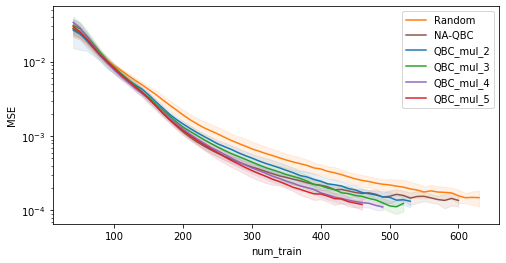

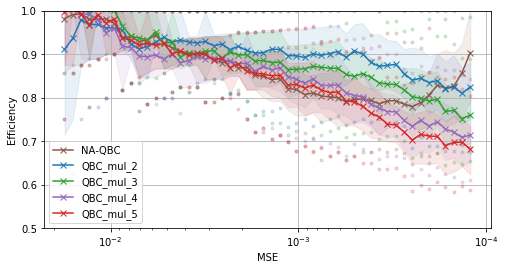

In [31]:
##################################
# The All method cluster comparison #
# ##################################
# algo_list = ['Random', 'MSE','QBC','NA-QBC', 'NAMD-QBC','Core-set','Dropout']
# # algo_list = ['Random', 'MSE','QBC','Core-set','Dropout']
# file_name_map =   {'Random':'Random', 'MSE':'MSE', 'QBC':'VAR','NA-QBC':'NAinit_',
#             'NAMD-QBC':'NAMD_POW','Core-set':'Core-set','Dropout':'Dropout'}
# test_mse_mat_name = {'Random':'Random_test_mse_mat', 'MSE':'MSE_test_mse_mat', 
#                     'QBC':'VAR_test_mse_mat','NA-QBC':'NA_test_mse_mat','NAMD-QBC':'NAMD_test_mse_mat',
#                     'Core-set':'CORE_test_mse_mat','Dropout':'DROP_test_mse_mat'}
# color_map = {'Random':'tab:orange', 'MSE':'tab:blue', 'QBC':'tab:green','NA-QBC':'tab:brown',
#             'NAMD-QBC':'tab:red','Core-set':'tab:olive','Dropout':'tab:purple'}


# algo_list = ['Random', 'MSE','QBC','NA-QBC', 'NAMD-QBC','Core-set','Dropout']
# file_name_map =   {'Random':'Random', 'MSE':'MSE', 'QBC':'VAR','NA-QBC':'NAinit_10_',
#             'NAMD-QBC':'NAMD_POWinit_10_','Core-set':'Core-set','Dropout':'Dropoutp_0.5'}
# test_mse_mat_name = {'Random':'Random_test_mse_mat', 'MSE':'MSE_test_mse_mat', 
#                     'QBC':'VAR_test_mse_mat','NA-QBC':'NA_test_mse_mat','NAMD-QBC':'NAMD_test_mse_mat',
#                     'Core-set':'CORE_test_mse_mat','Dropout':'DROP_test_mse_mat'}
# color_map = {'Random':'tab:orange', 'MSE':'tab:blue', 'QBC':'tab:green','NA-QBC':'tab:brown',
            # 'NAMD-QBC':'tab:red','Core-set':'tab:olive','Dropout':'tab:purple'}

#######################
# The VAR comparison #
######################
base_dx = 10
algo_list = ['Random', 'NA-QBC']
file_name_map =   {'Random':'Random', 'NA-QBC':'NAinit_'}
color_map = {'Random':'tab:orange', 'NA-QBC':'tab:brown'}
test_mse_mat_name = {'Random':'Random_test_mse_mat','NA-QBC':'NA_test_mse_mat'}
color_list = ['tab:blue', 'tab:green','tab:purple', 'tab:red', 'tab:olive','tab:grey']
# for ind, mul in enumerate([20, 10, 5, 4, 3,2]):
for ind, mul in enumerate([2,3,4,5,10,20]):
    algo_list.append('QBC_mul_{}'.format(mul))
    file_name_map['QBC_mul_{}'.format(mul)] = 'VAR_*pool_{}_*'.format(mul*base_dx)
    test_mse_mat_name['QBC_mul_{}'.format(mul)] = 'QBC_mul_{}_test_mse_mat'.format(mul)
    color_map['QBC_mul_{}'.format(mul)] = color_list[ind]

# folder_list = ['/home/sr365/NAAL/results/Stack_num_layer_9_nuron_700_nmod_10_toMSE_3e-05_dx_5_naal_True_reg_0_lr_0.001_decay_0.8']
folder_list = ['/home/sr365/NAAL/results/robo_num_layer_4_nuron_500_nmod_10_toMSE_0.0001_dx_10_naal_True_reg_0.0001_lr_0.001_decay_0.8']

##################################
# The NA pure cluster comparison #
##################################
# algo_list = ['Random', 'NAinit_10_','NAinit_20_','NAinit_50_', 'NAinit_100_', 'NAinit_1000_']
# file_name_map =   {'Random':'Random', 'NAinit_10_':'NAinit_10_', 'NAinit_20_':'NAinit_20_','NAinit_50_':'NAinit_50_',
#             'NAinit_100_':'NAinit_100_','NAinit_1000_':'NAinit_1000_'}
# test_mse_mat_name = {'Random':'Random_test_mse_mat', 'NAinit_10_':'NAinit_10__test_mse_mat', 'NAinit_20_':'NAinit_20__test_mse_mat', 
#                     'NAinit_50_':'NAinit_50__test_mse_mat', 'NAinit_100_':'NAinit_100__test_mse_mat', 'NAinit_1000_':'NAinit_1000__test_mse_mat'}
# color_map = {'Random':'tab:orange', 'NAinit_10_':'tab:blue', 'NAinit_20_':'tab:green','NAinit_50_':'tab:brown',
#             'NAinit_100_':'tab:red', 'NAinit_1000_':'tab:purple'}

##################################
# The NAMD cluster comparison #
#################################
# algo_list = ['Random', 'NAMD_POWinit_10_','NAMD_POWinit_20_','NAMD_POWinit_50_', 'NAMD_POWinit_100_', 'NAMD_POWinit_1000_']
# file_name_map =   {'Random':'Random', 'NAMD_POWinit_10_':'NAMD_POWinit_10_', 'NAMD_POWinit_20_':'NAMD_POWinit_20_','NAMD_POWinit_50_':'NAMD_POWinit_50_',
#             'NAMD_POWinit_100_':'NAMD_POWinit_100_','NAMD_POWinit_1000_':'NAMD_POWinit_1000_'}
# test_mse_mat_name = {'Random':'Random_test_mse_mat', 'NAMD_POWinit_10_':'NAMD_POWinit_10__test_mse_mat', 'NAMD_POWinit_20_':'NAMD_POWinit_20__test_mse_mat', 
#                     'NAMD_POWinit_50_':'NAMD_POWinit_50__test_mse_mat', 'NAMD_POWinit_100_':'NAMD_POWinit_100__test_mse_mat', 'NAMD_POWinit_1000_':'NAMD_POWinit_1000__test_mse_mat'}
# color_map = {'Random':'tab:orange', 'NAMD_POWinit_10_':'tab:blue', 'NAMD_POWinit_20_':'tab:green','NAMD_POWinit_50_':'tab:brown',
#             'NAMD_POWinit_100_':'tab:red', 'NAMD_POWinit_1000_':'tab:purple'}
# folder_list = ['/home/sr365/NAAL/results/sine_num_layer_9_nuron_20_nmod_10_toMSE_0.0005_dx_10_pool_mul_5_naal_True']
# folder_list = ['/home/sr365/NAAL/results/robo_num_layer_4_nuron_500_nmod_10_toMSE_0.0001_dx_10_pool_mul_5_naal_True']
# folder_list = ['/home/sr365/NAAL/results/Stack_num_layer_9_nuron_700_nmod_10_toMSE_2e-05_dx_5_pool_mul_5_naal_True']        # THE NA SWEEP
# folder_list = ['/home/sr365/NAAL/results/Stack_num_layer_9_nuron_700_nmod_10_toMSE_2e-05_dx_5_pool_mul_2_naal_True']           # THE MICS
# folder_list = ['/home/sr365/NAAL/results/ADM_num_layer_8_nuron_1500_nmod_10_toMSE_0.002_dx_50_pool_mul_5_naal_True']
# folder_list = ['/home/sr365/NAAL/results/sine_num_layer_9_nuron_20_nmod_10_toMSE_0.0003_dx_10_pool_mul_2_naal_True']
# folder_list = ['/home/sr365/NAAL/results/sine_num_layer_9_nuron_20_nmod_10_toMSE_0.0003_dx_10_pool_mul_2_naal_True/x0_60']
for folder in folder_list:
    # Decide the num_trails here
    cur_path = Path(folder)
    for i in range(10):
        glob_list = glob(os.path.join(cur_path, '*trail_{}'.format(10-i-1)))
        if glob_list:
            num_trails = 10-i
            print('num_trails should be ', num_trails)
            break
    cur_folder = glob(os.path.join(folder,'*Random*0'))[0]
    # Makue sure this is a folder
    if not os.path.isdir(cur_folder):
        continue
    # This is for the case where it is not called
    test_mse_mat, train_mse_mat, selected_after_train_mse_mat = {}, {}, {}
    print(algo_list)
    # Get the mats
    for algo in algo_list.copy():
        # print('working at algo:', algo)
        # Using the ambiguous matching scheme with glob
        cur_path = Path(cur_folder)
        glob_list = glob(os.path.join(cur_path.parent ,'*' + file_name_map[algo] +'*'+cur_folder.split('trail_')[-1]))
        print(glob_list)
        try:
            assert len(glob_list) == 1, 'your glob list is not 1 in the Dropout folder retrieving'
            drop_folder = glob_list[0]
            test_mse_mat[algo], train_mse_mat[algo], selected_after_train_mse_mat[algo] = load_matrix(drop_folder, num_trails)
            print(algo, 'loaded!')
            # print('shape of mat loaded', np.shape(test_mse_mat[algo][0]))
        except:
            # print('removing algo:', algo)
            algo_list.remove(algo)
    
    print('algo_list is', algo_list)

    # Smoothing
    for i in range(num_trails):
        for algo in algo_list:
            test_mse_mat[algo][i] = smooth(test_mse_mat[algo][i])

    # Get the x axis numbers
    dx, x0 = get_dx_x0(cur_folder)
    # Use the xlabel with number of data points
    x_label = np.array(range(2000)) * dx + x0

    # save_name = cur_folder.replace('MSE_','').replace('_trail_0_','')
    save_name = folder + '/'
    plot_test_MSE_plot(x_label, save_name, test_mse_mat, algo_list, plot_agg_only=True)
    Data_efficiency_plot(x_label, save_name, test_mse_mat, algo_list, y_lim_high=1)
